# **Project - Reinforcement Learning**

In [1]:
# %%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter

import gymnasium as gym


## Model Defination

In [2]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self, layer_dims = [8,16,16,4]):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layer_dims[i], layer_dims[i+1]) for i in range(0, len(layer_dims)-1)])
        self.act = torch.nn.ReLU()
        # self.fc1 = nn.Linear(8, 16)
        # self.fc2 = nn.Linear(16, 16)
        # self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        # hid = torch.tanh(self.fc1(state))
        # hid = torch.tanh(self.fc2(hid))
        # return F.softmax(self.fc3(hid), dim=-1)
        
        hid = self.act(self.linears[0](state))
        for li in self.linears[1:-1]:
            hid = self.act(li(hid))
        # return F.softmax(self.linears[-1](hid), dim=-1)
        return self.linears[-1](hid)
    
class PolicyGradientAgent():
    def __init__(self, network, device='cuda', optimizer = 'sgd'):
        self.network = network
        self.network.to(device)
        self.device = device
        
        if optimizer == 'sgd':
            self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)
        elif optim == 'adam':
            self.optimizer = optim.Adam(self.network.parameters(), lr=0.001)
        else:
            self.optimizer = optim.SGD(self.network.parameters(), lr=0.001)

    def learn(self, log_probs, rewards):
        log_probs = log_probs.to(self.device)
        rewards = rewards.to(self.device)
        
        loss = (-log_probs * rewards).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sample(self, state):
        action_prob = self.network(torch.FloatTensor(state).to(self.device))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

## Model Training

In [19]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
initial_state = env.reset()

"""
    Configurations
"""
device = 'cuda'
optimizer = 'adam'   # sgd, adam
# layer_dims = [8, 16, 16, 4]
layer_dims = [8, 16, 8, 4]

EPISODE_PER_BATCH = 7  # Update the agent every 5 episodes collected
NUM_BATCH = 500        # 400 updates in total

# Prepare writer
writer = SummaryWriter(f'runs/PG-{"-".join(str(x) for x in [layer_dims])}-{optimizer}-{NUM_BATCH}-{EPISODE_PER_BATCH}-{device}')

network = PolicyGradientNetwork(layer_dims=layer_dims)
agent = PolicyGradientAgent(network, optimizer=optimizer, device=device)

agent.network.train()  # Before training, please make sure that the network is in training mode
avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    # Collect training data
    for episode in range(EPISODE_PER_BATCH):
        state, _ = env.reset()
        total_reward, total_step = 0, 0
        
        DONE = False
        while not DONE:
            action, log_prob = agent.sample(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            log_probs.append(log_prob)
            state = next_state
            total_reward += reward
            total_step += 1
            DONE = terminated or truncated
            
        final_rewards.append(reward)
        total_rewards.append(total_reward)
        rewards.append(np.full(total_step, total_reward))  # Set the same episode, and the reward of each action is total reward
            
    # Record the training process
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    
    writer.add_scalar('avg_total_reward', avg_total_reward, batch)
    writer.add_scalar('avg_final_reward', avg_final_reward, batch)
    
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # Update the network
    rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # Normalize reward
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))

  0%|          | 0/500 [00:00<?, ?it/s]

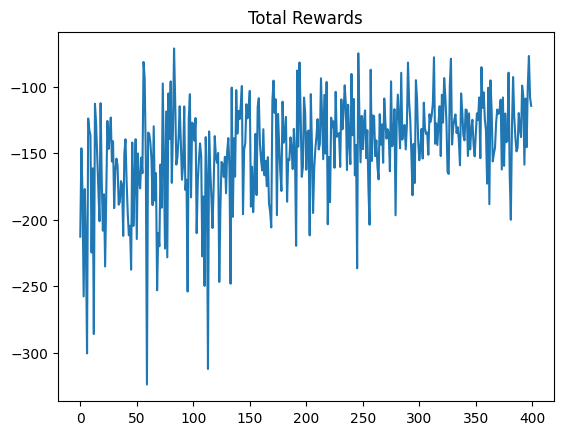

In [4]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

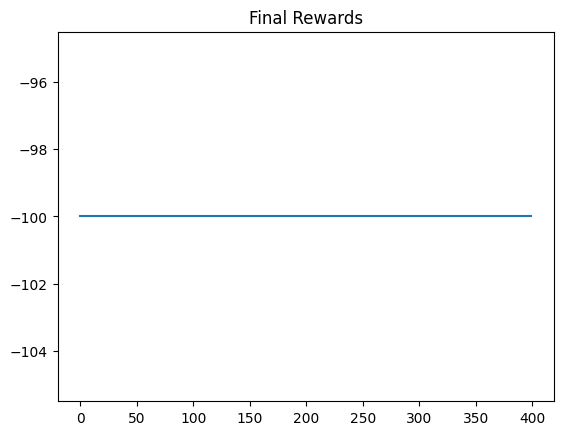

In [5]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Model Testing

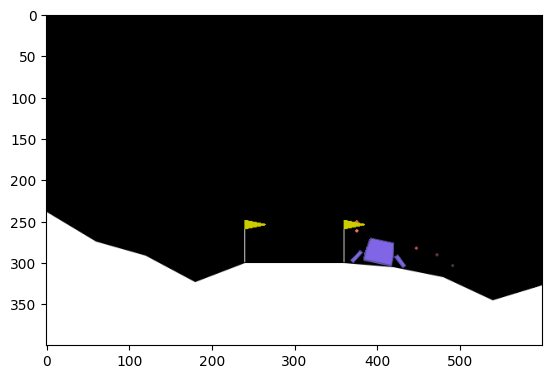

In [6]:
agent.network.eval()  # Switch the network to the evaluation mode before testing
state, _ = env.reset()
img = plt.imshow(env.render())
total_reward = 0

done = False
while not done:
    action, _ = agent.sample(state)
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    total_reward += reward
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [7]:
print(total_reward)

-161.20063001530892
